In [1]:
import ambulance_game as abg
import numpy as np
import matplotlib.pyplot as plt

## Others
$$
    W^{(o)} = \frac{\sum_{(u,v) \, \in S_A} \frac{1}{C \mu} \times max(v-C+1,0) \times \pi(u,v)}{\sum_{(u,v) \, \in S_A} \pi(u,v)}
$$

#### OR
$$ 
\vec{W} = \left[\frac{1}{C\mu}, \frac{1}{C\mu}, \dots, \frac{1}{C\mu} \right],
\hspace{1cm}
|\vec{W}| = M,
\hspace{1cm}
\vec{D} = 
\begin{bmatrix}
    0 \\ 
    \vdots \\ 
    0 \\
    1 \\
    2 \\
    \vdots \\
    N - C \\
\end{bmatrix}, 
\hspace{1cm}
|\vec{D}| = N
$$

$$
\vec{W} \pi_M \vec{D}
$$

## Ambulance
$$
    W^{(a)} = \frac{\sum_{(u,v) \, \in S_A} \frac{1}{C \mu} \times max(min(v+1,T)-C,0) \times \pi(u,v)}{\sum_{(u,v) \, \in S_A} \pi(u,v)}
$$

In [2]:
def is_accepting_state(state, patient_type, system_capacity, parking_capacity):
    if patient_type == "ambulance":
        condition = state[0] < parking_capacity
    if patient_type == "others":
        condition = state[1] < system_capacity
    return condition

In [3]:
def get_closed_form_waiting_time(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    output="both",
):

    all_states = abg.markov.build_states(
        threshold=threshold,
        system_capacity=system_capacity,
        parking_capacity=parking_capacity,
    )
    transition_matrix = abg.markov.get_transition_matrix(
        lambda_a=lambda_a,
        lambda_o=lambda_o,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        parking_capacity=parking_capacity,
    )
    pi = abg.markov.get_steady_state_algebraically(Q=transition_matrix)
    pi_array = abg.markov.get_markov_state_probabilities(pi, all_states)
    sojourn_time = 1 / (num_of_servers * mu)

    if output == "others":
        mean_waiting_time = sum([max(state[1] - num_of_servers + 1, 0) * pi_array[state] * sojourn_time for state in all_states if is_accepting_state(state, output, system_capacity, parking_capacity)]) / sum([pi_array[state] for state in all_states if is_accepting_state(state, output, system_capacity, parking_capacity)])
    if output == "ambulance":
        mean_waiting_time = np.sum([max(min(state[1] + 1, threshold) - num_of_servers, 0) * pi_array[state] * sojourn_time for state in all_states if is_accepting_state(state, output, system_capacity, parking_capacity)]) / sum([pi_array[state] for state in all_states if is_accepting_state(state, output, system_capacity, parking_capacity)])
    return mean_waiting_time

##### Comparing recursive formula and closed form


In [4]:
lambda_a = 0.2
lambda_o = 0.3
mu = 0.07
num_of_servers = 7
threshold = 10
system_capacity = 15
parking_capacity = 10

output_1 = "others"
output_2 = "ambulance"


In [5]:
def compare_recursive_closed_form(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    plot_over,
    max_parameter_value,
    accuracy,
):

    others_closed_form_values = []
    others_recursive_values = []

    ambulance_closed_form_values = []
    ambulance_recursive_values = []

    starting_value = locals()[plot_over]
    range_space = np.linspace(starting_value, max_parameter_value, accuracy)

    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_o = parameter
        elif plot_over == "mu":
            mu = parameter
        elif plot_over == "num_of_servers":
            num_of_servers = int(parameter)
        elif plot_over == "threshold":
            threshold = int(parameter)
        elif plot_over == "system_capacity":
            system_capacity = int(parameter)
        elif plot_over == "parking_capacity":
            parking_capacity = int(parameter)
        else:
            return "Invalid plot_over arguement"

        others_closed_form = get_closed_form_waiting_time(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            output="others",
        )
        others_recursive = abg.markov.get_mean_waiting_time_markov(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            output="others",
        )
        others_closed_form_values.append(others_closed_form)
        others_recursive_values.append(others_recursive)

        ambulance_closed_form = get_closed_form_waiting_time(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            output="ambulance",
        )
        ambulance_recursive = abg.markov.get_mean_waiting_time_markov(
            lambda_a=lambda_a,
            lambda_o=lambda_o,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
            output="ambulance",
        )
        ambulance_closed_form_values.append(ambulance_closed_form)
        ambulance_recursive_values.append(ambulance_recursive)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.plot(range_space, others_closed_form_values, label="Closed-form formula")
    plt.plot(range_space, others_recursive_values, label="Recursive formula")
    plt.legend()
    plt.title(
        "Other Patients (lambda_a="
        + str(lambda_a)
        + ", lambda_o="
        + str(lambda_o)
        + ", mu="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
        + ")"
    )
    plt.xlabel(plot_over)

    plt.subplot(1, 2, 2)
    plt.plot(range_space, ambulance_closed_form_values, label="Closed-form formula")
    plt.plot(range_space, ambulance_recursive_values, label="Recursive formula")
    plt.legend()
    plt.title(
        "Ambulance Patients (lambda_a="
        + str(lambda_a)
        + ", lambda_o="
        + str(lambda_o)
        + ", mu="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
        + ")"
    )
    plt.xlabel(plot_over)

    return (
        others_closed_form_values,
        ambulance_closed_form_values,
        others_recursive_values,
        ambulance_recursive_values,
    )


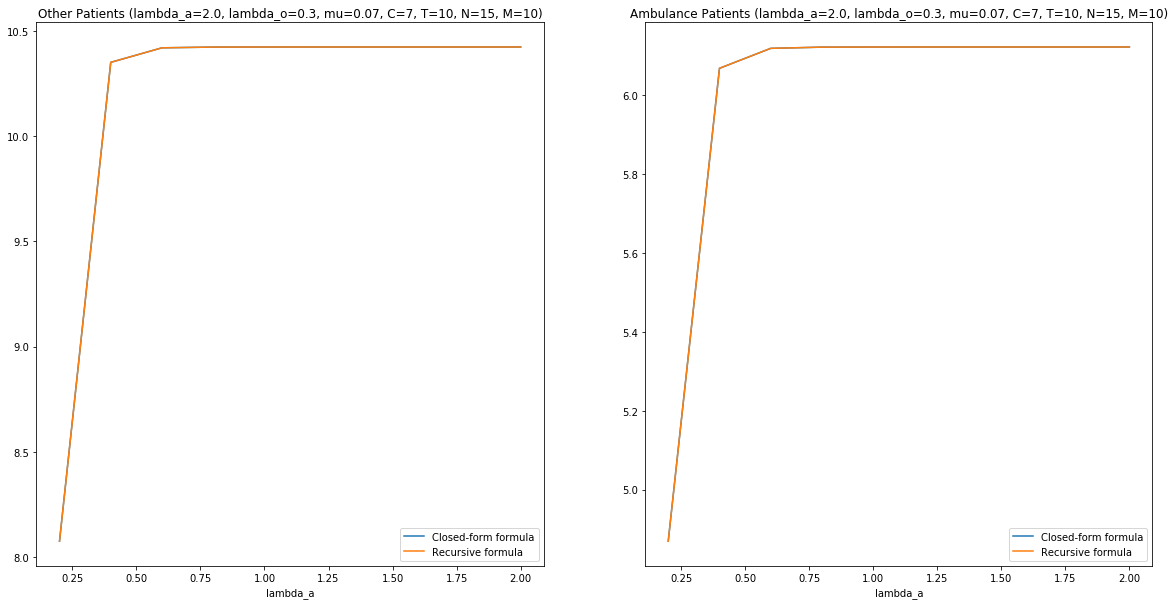

In [6]:
demo1, demo2, demo3, demo4 = compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over="lambda_a",
    max_parameter_value=2,
    accuracy=10,
)
plt.show()


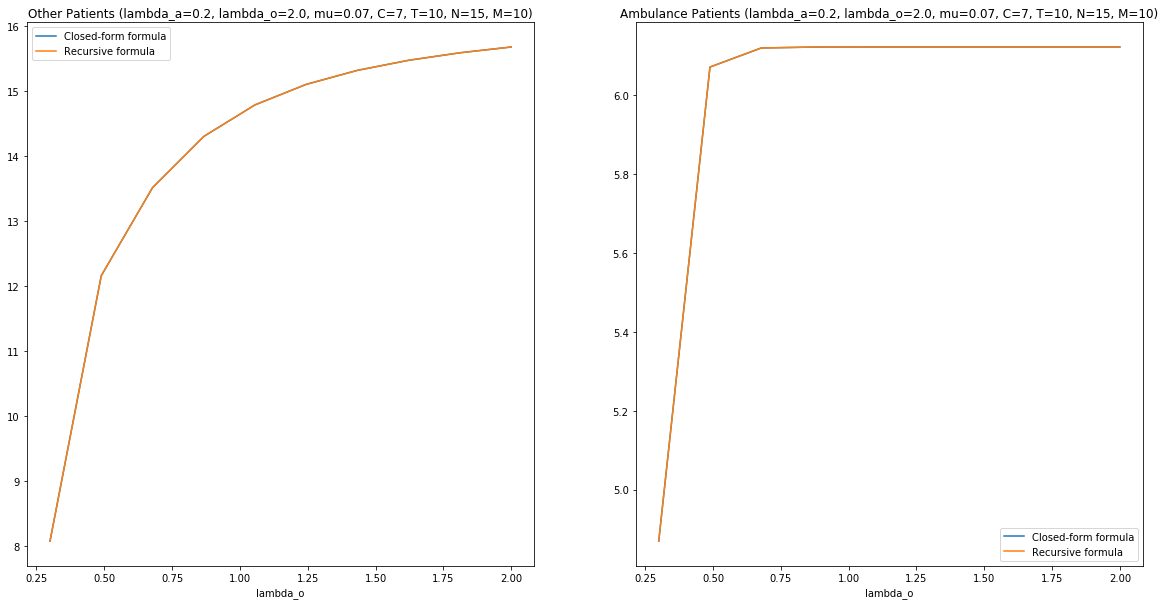

In [7]:
compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over="lambda_o",
    max_parameter_value=2,
    accuracy=10,
)
plt.show()


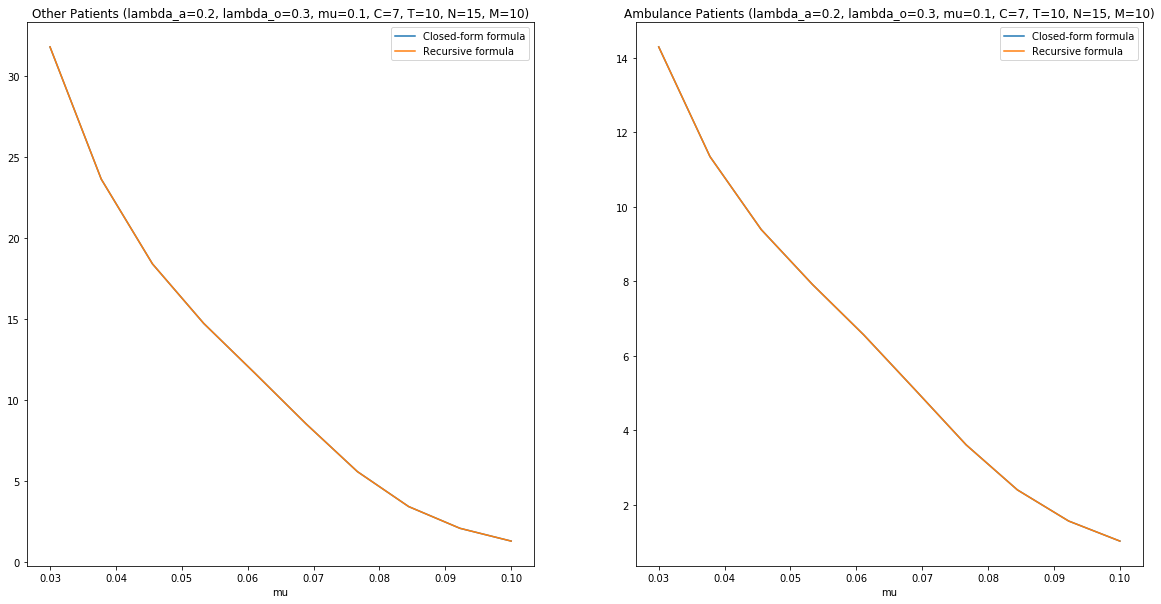

In [8]:
compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=0.03,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over="mu",
    max_parameter_value=0.1,
    accuracy=10,
)
plt.show()


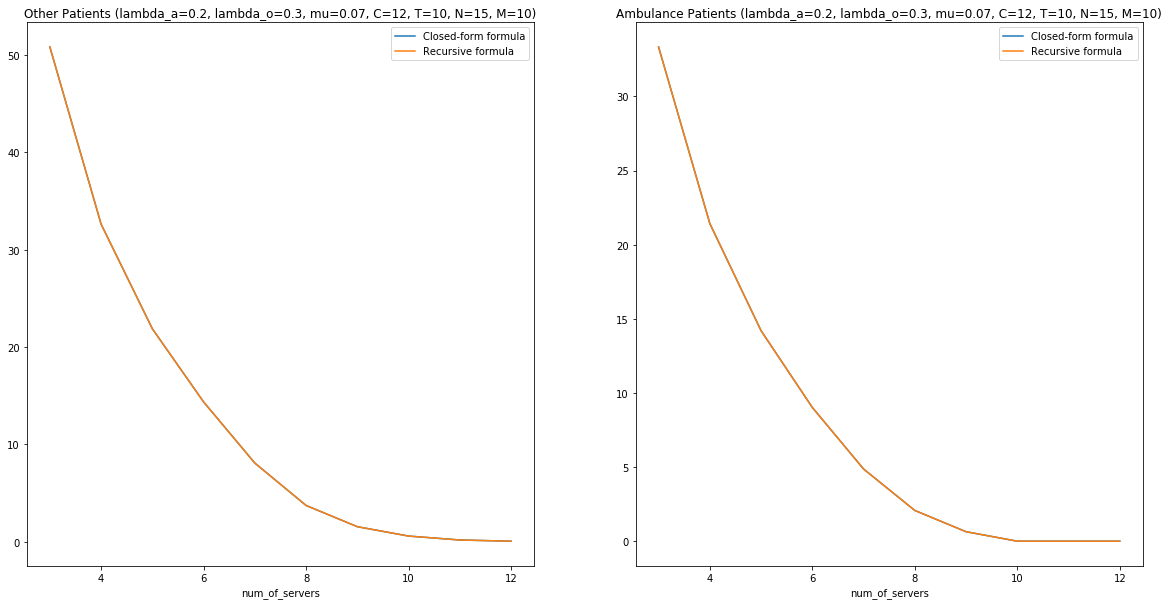

In [9]:
compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=3,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over="num_of_servers",
    max_parameter_value=12,
    accuracy=10,
)
plt.show()


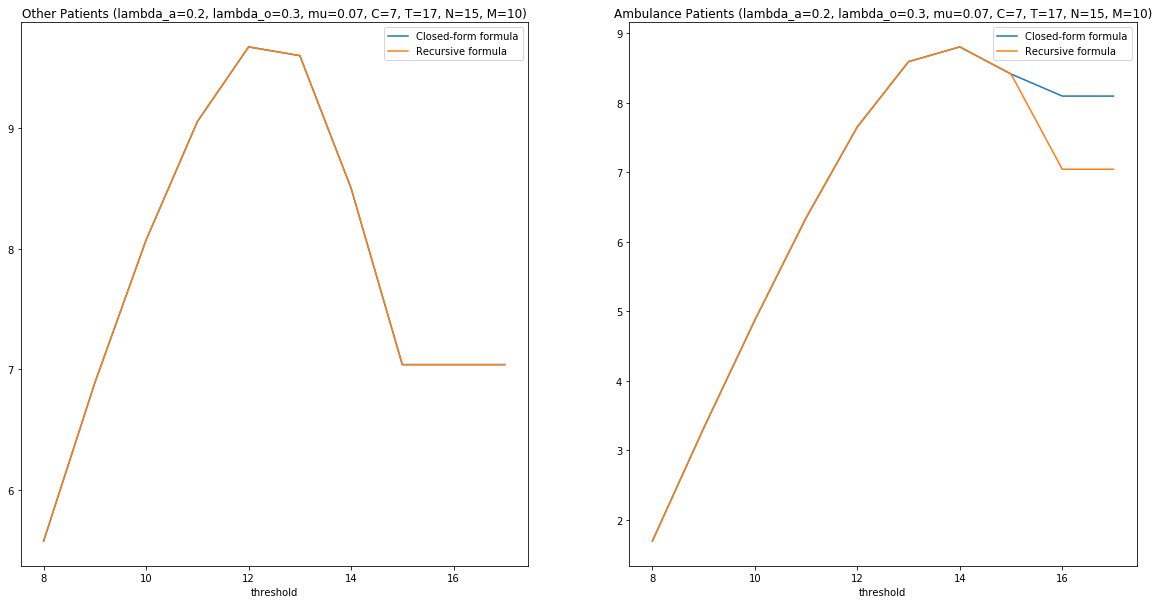

In [10]:
compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=8,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    plot_over="threshold",
    max_parameter_value=17,
    accuracy=10,
)
plt.show()


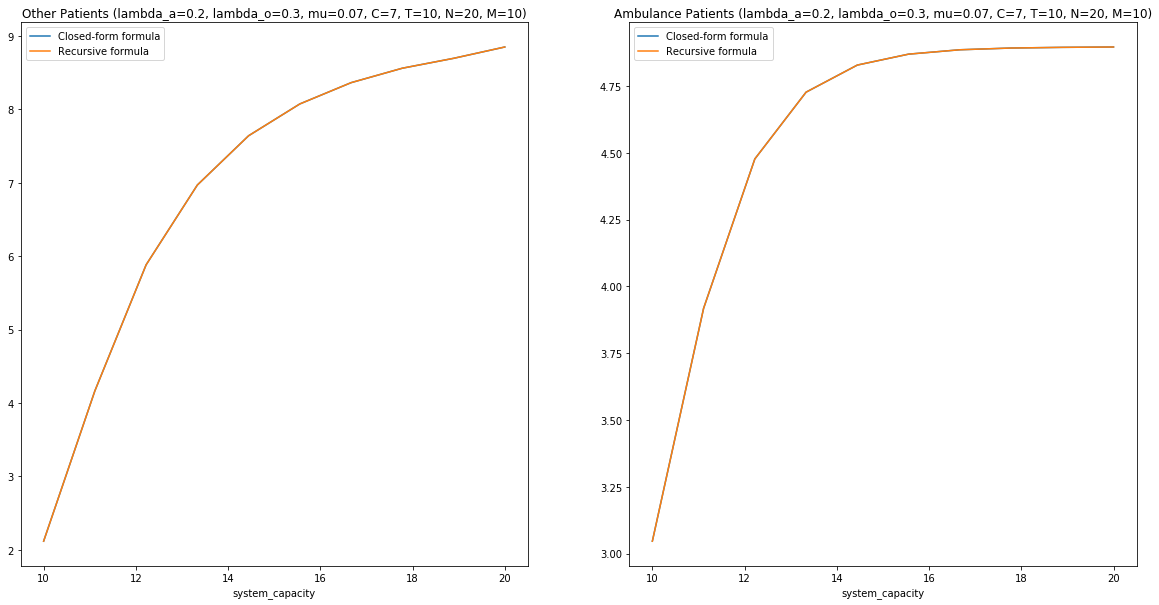

In [11]:
compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=10,
    parking_capacity=parking_capacity,
    plot_over="system_capacity",
    max_parameter_value=20,
    accuracy=10,
)
plt.show()


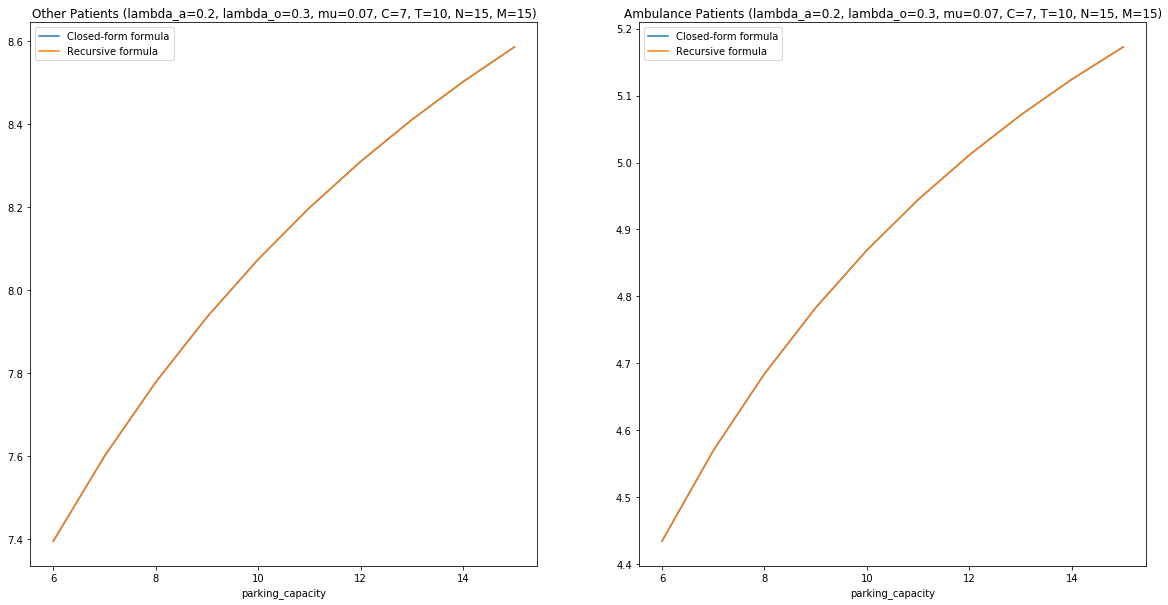

In [12]:
compare_recursive_closed_form(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=6,
    plot_over="parking_capacity",
    max_parameter_value=15,
    accuracy=10,
)
plt.show()


## Old attempt

In [3]:
def get_closed_form_waiting_time(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    output="both",
):

    all_states = abg.markov.build_states(
        threshold=threshold,
        system_capacity=system_capacity,
        parking_capacity=parking_capacity,
    )
    transition_matrix = abg.markov.get_transition_matrix(
        lambda_a=lambda_a,
        lambda_o=lambda_o,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        parking_capacity=parking_capacity,
    )
    pi = abg.markov.get_steady_state_algebraically(Q=transition_matrix)
    pi_array = abg.markov.get_markov_state_probabilities(pi, all_states)

    sojourn_time = 1 / (num_of_servers * mu)

    if output == "others":
        sojourn_array = (
            np.array(
                [
                    [
                        states_to_wait
                        for states_to_wait in range(
                            1, system_capacity - num_of_servers + 1
                        )
                    ]
                ]
            )
            * sojourn_time
        )  # for states_column in range(parking_capacity + 1)]) * sojourn_time
        mean_waiting_time = np.nansum(
            pi_array[:, num_of_servers:-1] * sojourn_array
        ) / np.nansum(pi_array[:, :-1])
        return mean_waiting_time

    if output == "ambulance":
        sojourn_array = (
            np.array(
                [
                    states_to_wait
                    for states_to_wait in range(1, threshold - num_of_servers + 1)
                ]
                + [
                    max(0, threshold - num_of_servers)
                    for states_to_wait in range(threshold, system_capacity + 1)
                ]
            )
            * sojourn_time
        )
        if threshold > system_capacity:
            mean_waiting_time = np.nansum(
                pi_array[:, min(num_of_servers, threshold) : -1] * sojourn_array[:-1]
            ) / np.nansum(pi_array[:, :-1])
            return mean_waiting_time

        mean_waiting_time = np.nansum(
            pi_array[:-1, min(num_of_servers, threshold) :] * sojourn_array
        ) / np.nansum(pi_array[:-1, :])
        return mean_waiting_time
